In [2]:
import os
import pytest

from skimage.io import imread
from skimage.transform import resize as imresize

from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions

from temporalnn.explain.lime import LIMEImage

inet_model = inc_net.InceptionV3()

DATA_DIR = "tests/data" if os.path.isdir("tests") else "data"


In [3]:
def predict_inception_v3(x):
    shape = None
    if x.ndim == 3:
        shape = (1, x.shape[0], x.shape[1], x.shape[2])
    if x.ndim == 2:
        shape = (1, x.shape[0], x.shape[1], 1)
    if not shape:
        raise ValueError(f"{x.shape}")
    _x = x.reshape(shape)
    prediction = inet_model.predict(_x)
    _, label, prob = decode_predictions(prediction)[0][0]
    return prob

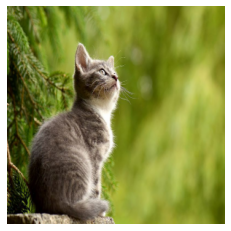

In [4]:
import matplotlib.pyplot as plt
img = imread(f"{DATA_DIR}/cat.jpg")
img_original = imresize(img, (299, 299))
plt.axis('off')
plt.imshow(img_original)

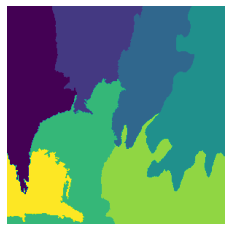

In [5]:
xai_img = LIMEImage(x=img_original, predict_fn=predict_inception_v3, sample_size=1000)
img_segmented, img_features = xai_img.to_features()
xai_img.x_segmented = img_segmented
xai_img.x_features = img_features

plt.axis('off')
plt.imshow(img_segmented)

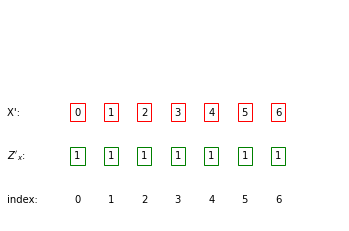

In [6]:
arr = img_features
row_relative = [0.5, 0.3, 0.1]

plt.axis('off')
plt.text(0, row_relative[0], r"X': ")
plt.text(0, row_relative[1], r"${Z'}_x$: ")
plt.text(0, row_relative[2], 'index:')
for i, c in enumerate(arr):
    plt.text((i + 2) * 0.1, row_relative[0], c, bbox=dict(facecolor='none', edgecolor='red'))
    plt.text((i + 2) * 0.1, row_relative[1], 1, bbox=dict(facecolor='none', edgecolor='green'))
    plt.text((i + 2) * 0.1, row_relative[2], i, )

In [7]:
z_comma = xai_img.sampling_features(img_features, n_features_on=4)

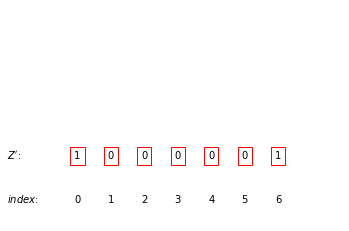

In [8]:
arr = z_comma[0]
row_relative = [0.3, 0.1]

plt.axis('off')
plt.text(0, row_relative[0], r"$Z'$: ")
plt.text(0, row_relative[1], r"$index$: ")
for i, c in enumerate(arr):
    plt.text((i + 2) * 0.1, row_relative[0], c, bbox=dict(facecolor='none', edgecolor='red'))
    plt.text((i + 2) * 0.1, row_relative[1], i, )

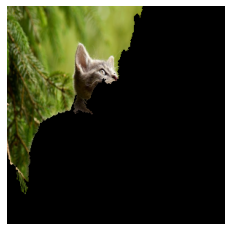

In [9]:
t = z_comma[0].astype(int)
z_original = xai_img.to_original_form(t)

plt.axis('off')
plt.imshow(z_original)

In [10]:
xai_model = xai_img.explain(sample_size=100)

In [11]:
xai_model.coef_

array([0.01622681, 0.03849782, 0.03576273, 0.04480125, 0.03866615,
       0.03989544, 0.04010081])

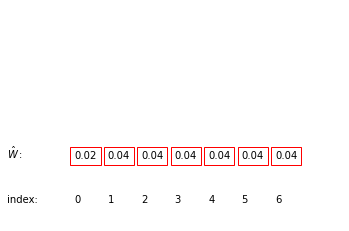

In [12]:
arr = xai_model.coef_.round(2)
row_relative = [0.3, 0.1]

plt.axis('off')
plt.text(0, row_relative[0], r"$\hatW:$ ")
plt.text(0, row_relative[1], 'index:')
for i, c in enumerate(arr):
    plt.text((i + 2) * 0.1, row_relative[0], c, bbox=dict(facecolor='none', edgecolor='red'))
    plt.text((i + 2) * 0.1, row_relative[1], i, )

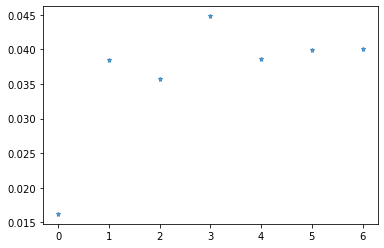

In [13]:
plt.plot(xai_model.coef_, alpha=0.7, linestyle='none', marker='*', markersize=5)
